# GAN for Anime Face Generation - Full Implementation

## Step 1: Install Required Libraries

In [ ]:
!pip install torch torchvision Pillow pytorch-fid
import urllib
import os

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [ ]:
!ls /content/

archive.zip  sample_data


In [ ]:
!unzip /content/archive.zip -d /content/extracted_images/

Streaming output truncated to the last 5000 lines.
  inflating: /content/extracted_images/images/62764_2019.jpg  
  inflating: /content/extracted_images/images/62765_2019.jpg  
  inflating: /content/extracted_images/images/62766_2019.jpg  
  inflating: /content/extracted_images/images/62767_2019.jpg  
  inflating: /content/extracted_images/images/62768_2019.jpg  
  inflating: /content/extracted_images/images/62769_2019.jpg  
  inflating: /content/extracted_images/images/6276_2003.jpg  
  inflating: /content/extracted_images/images/62770_2019.jpg  
  inflating: /content/extracted_images/images/62771_2019.jpg  
  inflating: /content/extracted_images/images/62772_2019.jpg  
  inflating: /content/extracted_images/images/62773_2019.jpg  
  inflating: /content/extracted_images/images/62774_2019.jpg  
  inflating: /content/extracted_images/images/62775_2019.jpg  
  inflating: /content/extracted_images/images/62776_2019.jpg  
  inflating: /content/extracted_images/images/62777_2019.jpg  
  inf

In [ ]:
!ls /content/extracted_images/

images


## Step 2: Load and Preprocess the Dataset

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class AnimeFaceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_filenames = [x for x in os.listdir(image_dir) if x.endswith(".jpg")]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = AnimeFaceDataset(image_dir='/content/extracted_images/images', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


## Step 3: Define Generator and Discriminator Models

In [ ]:
import torch
import torch.nn as nn

device = get_default_device()
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


## Step 4: Define Loss Functions and Optimizers

In [ ]:

import torch.optim as optim

criterion = nn.BCELoss()
lr = 0.0002

latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))



## Step 5: Training the GAN

Saving generated-images-0000.png


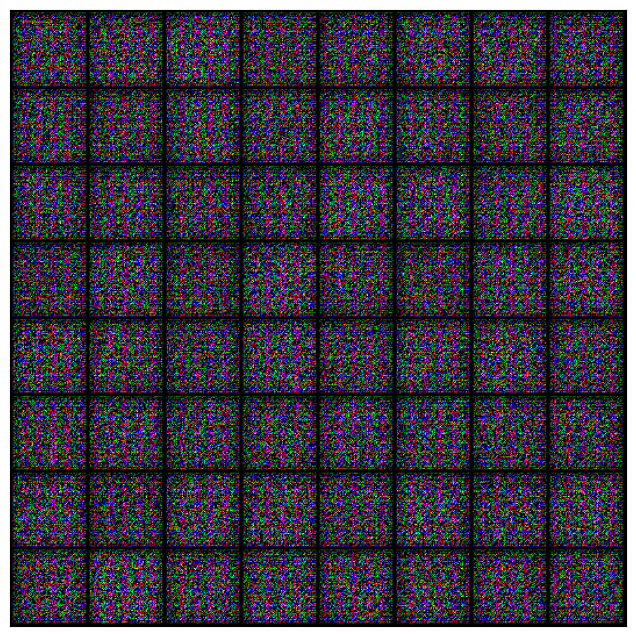

In [ ]:
from torchvision.utils import save_image
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
import os

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

fixed_latent = torch.randn(64, latent_dim, 1, 1, device=device)
save_samples(0, fixed_latent)

In [ ]:

import torch

print(device)
generator = generator.to(device)
discriminator = discriminator.to(device)
criterion = criterion.to(device)

real_label = 1.
fake_label = 0.

num_epochs = 50

start_index = 1
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        discriminator.zero_grad()

        real_images = data.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_images).view(-1)
        loss_real = criterion(output, labels)
        loss_real.backward()

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        labels.fill_(fake_label)
        output = discriminator(fake_images.detach()).view(-1)
        loss_fake = criterion(output, labels)
        loss_fake.backward()

        optimizer_D.step()

        generator.zero_grad()
        labels.fill_(real_label)
        output = discriminator(fake_images).view(-1)
        loss_G = criterion(output, labels)
        loss_G.backward()
        optimizer_G.step()


        if i % 50 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)}                   Loss D: {loss_real + loss_fake:.4f}, Loss G: {loss_G:.4f}')
        # Save generated images
    save_samples(epoch+start_index, fixed_latent, show=False)
    start_index += 1
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(torch.randn(64, latent_dim, 1, 1, device=device)).detach().cpu()


cuda
Epoch [0/50] Batch 0/994                   Loss D: 1.5887, Loss G: 3.0777
Epoch [0/50] Batch 50/994                   Loss D: 0.6132, Loss G: 14.0583
Epoch [0/50] Batch 100/994                   Loss D: 0.8117, Loss G: 2.3326
Epoch [0/50] Batch 150/994                   Loss D: 0.5729, Loss G: 5.3846
Epoch [0/50] Batch 200/994                   Loss D: 0.6029, Loss G: 5.5795
Epoch [0/50] Batch 250/994                   Loss D: 0.9824, Loss G: 6.7338
Epoch [0/50] Batch 300/994                   Loss D: 0.2972, Loss G: 6.3911
Epoch [0/50] Batch 350/994                   Loss D: 0.1322, Loss G: 3.8591
Epoch [0/50] Batch 400/994                   Loss D: 0.9851, Loss G: 10.0520
Epoch [0/50] Batch 450/994                   Loss D: 1.6241, Loss G: 8.6906
Epoch [0/50] Batch 500/994                   Loss D: 0.2815, Loss G: 5.4964
Epoch [0/50] Batch 550/994                   Loss D: 0.4952, Loss G: 3.0965
Epoch [0/50] Batch 600/994                   Loss D: 1.0198, Loss G: 9.9860
Epoch [0

## Step 6: Evaluating Model Performance with FID

In [ ]:
from PIL import Image
import os

def resize_images_in_directory(directory, size=(64, 64)):
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            with Image.open(img_path) as img:
                img_resized = img.resize(size)
                img_resized.save(img_path)  # Overwrite or save to a new path
# Apply this function to both real and generated image directories
resize_images_in_directory('/content/extracted_images/images', size=(64, 64))
resize_images_in_directory('/content/generated', size=(64, 64))


In [ ]:
!pip install pytorch-fid # Install the pytorch-fid library
from pytorch_fid import fid_score # Import the fid_score module

# Define the paths to the real and generated image directories
real_img_dir = '/content/extracted_images/images'  # Replace with your path
generated_img_dir = '/content/generated' # Replace with your path

fid_value = fid_score.calculate_fid_given_paths(
    [real_img_dir, generated_img_dir],
    batch_size=64,
    device=device,
    dims=2048,  # Standard dimension for InceptionV3 features
    num_workers=0  # To avoid threading issues, run on main process
)
print(f"FID score: {fid_value}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 240MB/s]
100%|██████████| 994/994 [04:16<00:00,  3.87it/s]


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


FID score: 354.85813850444697


## Step 7: Visualize Generated Images

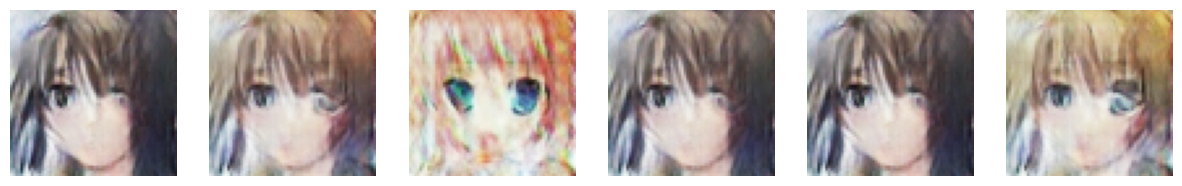

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def visualize_generated_images(generator, latent_dim, num_images=6):
    noise = torch.randn(num_images, latent_dim, 1, 1, device=device)

    with torch.no_grad():
        generated_images = generator(noise).detach().cpu().numpy()

    generated_images = (generated_images + 1) / 2

    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        img = np.transpose(generated_images[i], (1, 2, 0))
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

# Call the function to visualize generated images
visualize_generated_images(generator, latent_dim)


In [ ]:
import cv2
import os

# Ensure the directory exists
image_folder = 'gan_generated_images/'
if not os.path.exists(image_folder):
  os.makedirs(image_folder)

video_name = 'gan_training_progress.mp4'

images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]

# Check if the 'images' list is empty
if not images:
    print("No PNG images found in the directory.")
else:
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 1, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

No PNG images found in the directory.
